<img src="https://raw.githubusercontent.com/EO-College/cubes-and-clouds/main/icons/cnc_3icons_share_cirlce.svg"
     alt="Cubes & Clouds logo"
     style="float: center; margin-right: 10px;" />

# 3.4 Data Sharing
Science is much more impactful once it's shared. Therefore, we are going to learn how to 
open up our scientific output from a cloud platform, so that is openly available - and 
has the chance to make the impact it should.
- Load data,
- Select AOI,
- Recreate process graph, 
- Download results for one time-step, 
- Generate STAC


## Libraries

In [1]:
import json

import openeo
import numpy as np
import leafmap

import geopandas as gpd
import shapely
from shapely.geometry import Polygon

import rioxarray as rio
import xarray

Import utility functions

In [2]:
%run cubes_utilities.py

## Login

Connect to the copernicus dataspace ecosystem.

In [3]:
conn = openeo.connect('https://openeo.dataspace.copernicus.eu/')

Authenticate login

In [4]:
conn.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.1/' with OidcBearerAuth>

Check if the login worked

In [ ]:
conn.describe_account()

## Select a Point of Interest
Start by selecting a center point of the area you would like to analyse from the map shown below

In [6]:
m = leafmap.Map(center=(46.497012, 11.356429), zoom=14)
m

Map(center=[46.497012, 11.356429], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

In [7]:
feat = m.draw_features
geom = feat[0]['geometry']['coordinates']

In [8]:
distance_km = 1
# Create a bounding box around the point
bbox = create_bounding_box(geom[0], geom[1], distance_km)
visualize_bbox(m, bbox)

## Recreate process graph

In [9]:
temporal_extent = ["2018-01-01", "2018-02-15"]
snow_map_4dcube = calculate_sca(conn, bbox, temporal_extent)
snow_map_4dcube

## Reduce dimension

In [10]:
snow_map_3dcube = snow_map_4dcube.reduce_dimension(reducer="median", dimension="t")
snow_map_3dcube

### Download result

In [13]:
# create a batch job
snowmap_cog = snow_map_3dcube.save_result(format = "GTiff") #, options = {"overviews": "AUTO"})

In [14]:
job = snowmap_cog.create_job(title="snowmap_cog")
job.start_job()

In [18]:
job.status()

'finished'

In [19]:
if job.status() == "finished":
    results = job.get_results()
    results.download_files("results/")

In [20]:
snowmap = rio.open_rasterio("results/openEO.tif",decode_coords="all")
snowmap

<xarray.DataArray (band: 1, y: 209, x: 145)>
[30305 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 6.837e+05 6.837e+05 ... 6.852e+05 6.852e+05
  * y            (y) float64 5.157e+06 5.157e+06 ... 5.155e+06 5.155e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:        Area
    PROCESSING_SOFTWARE:  0.19.2a1
    _FillValue:           nan
    scale_factor:         1.0
    add_offset:           0.0

### Visualize result

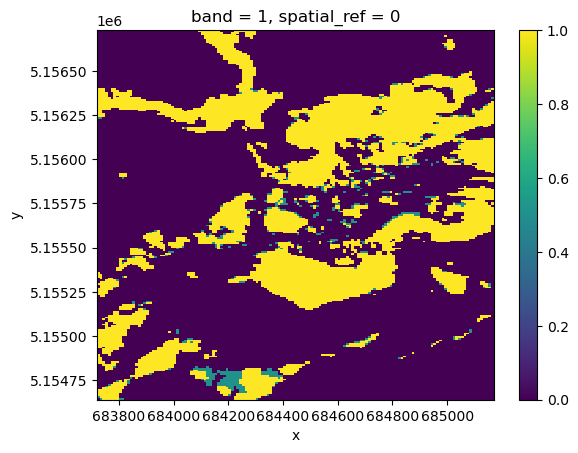

In [21]:
snowmap.plot()

In [22]:
stac_item = results.get_metadata()

In [23]:
stac_item

{'assets': {'openEO.tif': {'file:nodata': ['nan'],
   'href': 'https://openeo.dataspace.copernicus.eu/openeo/1.1/jobs/j-2311159d5c19419e97f9cd204828b161/results/assets/MDYxODNjYmMtODRjOC00YzZhLThhN2QtY2IxOGJhMDhjYzhj/d19e802d03e5e47b3e2b9556bee79313/openEO.tif?expires=1700646046',
   'proj:bbox': [683720.0, 5154640.0, 685170.0, 5156730.0],
   'proj:epsg': 32632,
   'proj:shape': [145, 209],
   'raster:bands': [{'name': '1',
     'statistics': {'maximum': 1.0,
      'mean': 0.26924599901006,
      'minimum': 0.0,
      'stddev': 0.43847078952239,
      'valid_percent': 100.0}}],
   'roles': ['data'],
   'title': 'openEO.tif',
   'type': 'image/tiff; application=geotiff'}},
 'description': 'Results for batch job j-2311159d5c19419e97f9cd204828b161',
 'extent': {'spatial': {'bbox': [[11.396102783940814,
     46.520292622936324,
     11.414089216059187,
     46.53864137706367]]},
  'temporal': {'interval': [['2018-01-01T00:00:00Z',
     '2018-02-15T00:00:00Z']]}},
 'id': 'j-2311159d5c19419e

In [25]:
stac_json = json.dumps(stac_item.to_dict())
with open("results/stac_item.json", "w") as file:
    file.write(stac_json)

AttributeError: 'dict' object has no attribute 'to_dict'